# Big Data and Cloud Computing - Assignment #2

Group AC

- Bárbara Nóbrega Galiza - 202408654
- Carolina Nunes Valente Pires - 202408704
- Cláudia Oliveira -  202005668

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, stddev, when, isnan, ceil, coalesce, to_timestamp, countDistinct, collect_list, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [3]:
spark = SparkSession.builder \
    .appName("ICU Length of Stay Prediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

25/05/21 16:39:50 WARN Utils: Your hostname, lenovo-barbara resolves to a loopback address: 127.0.1.1; using 172.17.21.171 instead (on interface wlan0)
25/05/21 16:39:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/21 16:39:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


This next chunk of code, differently from pandas, does not load the data immediatly to memory, it only builds a logical plan for the computation. However, it still take some time because it also does file discovery and infers schema from a sample (still an I/O operation).

In [4]:
start_time = time.time()

icustays = spark.read.csv("tables/ICUSTAYS.csv", header=True, inferSchema=True)
chartevents = spark.read.csv("tables/CHARTEVENTS_BIG.csv", header=True, inferSchema=True)
diagnoses = spark.read.csv('tables/DIAGNOSES_ICD.csv', header=True, inferSchema=True)
diagnosis_names = spark.read.csv('tables/D_ICD_DIAGNOSES.csv', header=True, inferSchema=True)
admissions = spark.read.csv('tables/ADMISSIONS.csv', header=True, inferSchema=True)
patients = spark.read.csv('tables/PATIENTS.csv', header=True, inferSchema=True)
items = spark.read.csv('tables/D_ITEMS.csv', header=True, inferSchema=True)


end_time = time.time()

print(f"Total CSV load time: {end_time - start_time:.2f} seconds")

Total CSV load time: 101.38 seconds


Checking if inferSchema worked:

In [5]:
print(icustays.describe()) # LOS infered as string, requires adjusting
print(chartevents.describe())
print(diagnoses.describe())
print(diagnosis_names.describe())
print(admissions.describe())
print(patients.describe())
print(items.describe())

DataFrame[summary: string, ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, ICUSTAY_ID: string, DBSOURCE: string, FIRST_CAREUNIT: string, LAST_CAREUNIT: string, FIRST_WARDID: string, LAST_WARDID: string, LOS: string]
DataFrame[summary: string, ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, ICUSTAY_ID: string, ITEMID: string, CGID: string, VALUE: string, VALUENUM: string, VALUEUOM: string, WARNING: string, ERROR: string, RESULTSTATUS: string, STOPPED: string]
DataFrame[summary: string, ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, SEQ_NUM: string, ICD9_CODE: string]
DataFrame[summary: string, ROW_ID: string, ICD9_CODE: string, SHORT_TITLE: string, LONG_TITLE: string]
DataFrame[summary: string, ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, ADMISSION_TYPE: string, ADMISSION_LOCATION: string, DISCHARGE_LOCATION: string, INSURANCE: string, LANGUAGE: string, RELIGION: string, MARITAL_STATUS: string, ETHNICITY: string, DIAGNOSIS: string, HOSPITAL_EXPIRE_FLAG: string, H

In [6]:
print(chartevents.count())

330712483


In [7]:
d = diagnoses.filter(col("ICD9_CODE").startswith("428"))
diagnoses_disease = d.filter(col("SEQ_NUM") == 1.0)

hadm_ids = [row["HADM_ID"] for row in diagnoses_disease.select("HADM_ID").distinct().collect()]
patient_ids = [row["SUBJECT_ID"] for row in diagnoses_disease.select("SUBJECT_ID").distinct().collect()]

In the next section, we initially believed the bottleneck was the filtering, but after printing execution times, we can see counting takes much longer and it seems to be the one causing the delay. After investigating, we learned the .filter() snippet does not run the filtering when called, but only creates de DAG, that is, defines the plan of execution. Therefore, the counting takes longer because it's where the filtering DAG is executed, which involves reading chartevents big dataframe from disk, parsing the csv, applying filter and reducing to final count.

In [8]:
start_time = time.time()
chartevents_filtered = chartevents.filter(col("HADM_ID").isin(hadm_ids))
end_time = time.time()

print(f"Total 'filtering' time: {end_time - start_time:.2f} seconds")

start_time = time.time()
print("Total number of chartevents for heart failure:", chartevents_filtered.count())
end_time = time.time()
print(f"Total counting time: {end_time - start_time:.2f} seconds")

chartevents_filtered.show(5)

Total 'filtering' time: 1.08 seconds


Total number of chartevents for heart failure: 7270413
Total counting time: 68.06 seconds
+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
| 27124|       165| 170252|    247247|223761|2170-10-03 18:00:00|2170-10-03 18:43:00|16187| 97.3|    97.3|      ?F|      0|    0|        NULL|   NULL|
| 27125|       165| 170252|    247247|225664|2170-10-03 18:00:00|2170-10-03 18:43:00|20277|  174|   174.0|    NULL|      0|    0|        NULL|   NULL|
| 27126|       165| 170252|    247247|220277|2170-10-03 18:35:00|2170-10-03 18:43:00|16187|   99|    99.0|       %|      0|    0|        NULL|   NULL|
| 27

## Data preprocessing 

In [9]:
patients = patients.filter(col("SUBJECT_ID").isin(patient_ids))
admissions = admissions.filter(col("HADM_ID").isin(hadm_ids))
icustays = icustays.filter(col("HADM_ID").isin(hadm_ids))

items.show(5)

+------+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|ROW_ID|ITEMID|               LABEL|ABBREVIATION|DBSOURCE|    LINKSTO|CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|   457|   497|Patient controlle...|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   458|   498|   PCA Lockout (Min)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   459|   499|      PCA Medication|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   460|   500|      PCA Total Dose|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   461|   501|  PCV Exh Vt (Obser)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
+------+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
only showi

In [10]:
print("Número de linhas em icustays:", icustays.count())
print("Número de linhas em admissions:", admissions.count())
print("Número de linhas em patients:", patients.count())

Número de linhas em icustays: 1623
Número de linhas em admissions: 1488
Número de linhas em patients: 1268


Comorbidities

In [11]:
diag_filtered = diagnoses.filter(
    (col("HADM_ID").isin(hadm_ids)) & (col("SEQ_NUM") > 1)
)

grouped = diag_filtered.groupBy("HADM_ID").agg(
    collect_list("ICD9_CODE").alias("ICD9_CODE")
)

grouped.show(5, truncate=False)


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|HADM_ID|ICD9_CODE                                                                                                                                                         |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|100050 |[99811, 5990, 4241, 41401, 2875, 99791, 42731, 53081, V4501]                                                                                                      |
|100061 |[5849, 4160, 4280, 496, 25060, 3572, 4439, V4582, V1254]                                                                                                          |
|100136 |[51882, 486, 42731, 4019, 2724, 45829, E9444, 2859, 7821]                                                                     

In [12]:
# Filtrar diagnósticos com SEQ_NUM == 2.0 e renomear ICD9_CODE → comorbidity1
diag_seq2 = diagnoses.filter(col("SEQ_NUM") == 2.0) \
    .select("HADM_ID", col("ICD9_CODE").alias("comorbidity1"))

# Left join com diagnoses_disease
diagnoses_disease = diagnoses_disease.join(diag_seq2, on="HADM_ID", how="left")

# Substituir nulos por 0 na comorbidity1
diagnoses_disease = diagnoses_disease.withColumn(
    "comorbidity1",
    when(col("comorbidity1").isNull(), lit("0")).otherwise(col("comorbidity1"))
)

# Repetir o mesmo para SEQ_NUM == 3.0 → comorbidity2
diag_seq3 = diagnoses.filter(col("SEQ_NUM") == 3.0) \
    .select("HADM_ID", col("ICD9_CODE").alias("comorbidity2"))

diagnoses_disease = diagnoses_disease.join(diag_seq3, on="HADM_ID", how="left")

diagnoses_disease = diagnoses_disease.withColumn(
    "comorbidity2",
    when(col("comorbidity2").isNull(), lit("0")).otherwise(col("comorbidity2"))
)

# Verificar resultados
diagnoses_disease.show(15, truncate=False)


+-------+------+----------+-------+---------+------------+------------+
|HADM_ID|ROW_ID|SUBJECT_ID|SEQ_NUM|ICD9_CODE|comorbidity1|comorbidity2|
+-------+------+----------+-------+---------+------------+------------+
|185360 |2460  |199       |1      |4280     |4254        |4240        |
|153627 |5001  |414       |1      |4280     |5119        |42731       |
|135828 |2163  |176       |1      |4280     |42731       |4251        |
|186199 |5839  |495       |1      |4280     |5845        |7895        |
|174800 |4092  |351       |1      |4280     |78057       |6110        |
|136326 |7557  |654       |1      |4280     |486         |51881       |
|155866 |7546  |653       |1      |42831    |42731       |5990        |
|176764 |2154  |175       |1      |42831    |51881       |5070        |
|106158 |3775  |323       |1      |4280     |99672       |99762       |
|117029 |5078  |422       |1      |42833    |51881       |2762        |
|157083 |5792  |491       |1      |42831    |99602       |9971  

In [13]:
# Contar frequência dos códigos da comorbidity1
counts1_df = diagnoses_disease.groupBy("comorbidity1").count().orderBy(col("count").desc())

# Coletar os resultados para análise em Python (porque plot é local, não Spark)
counts1 = counts1_df.toPandas().set_index("comorbidity1")["count"]

# Calcular percentagem dos top 5
top5_total = counts1.iloc[:5].sum()
total = counts1.sum()
c1 = top5_total / total

print("Percentage of the frequency explained by the top 5 comorbidities: {:.2f} %".format(c1 * 100))


Percentage of the frequency explained by the top 5 comorbidities: 44.02 %


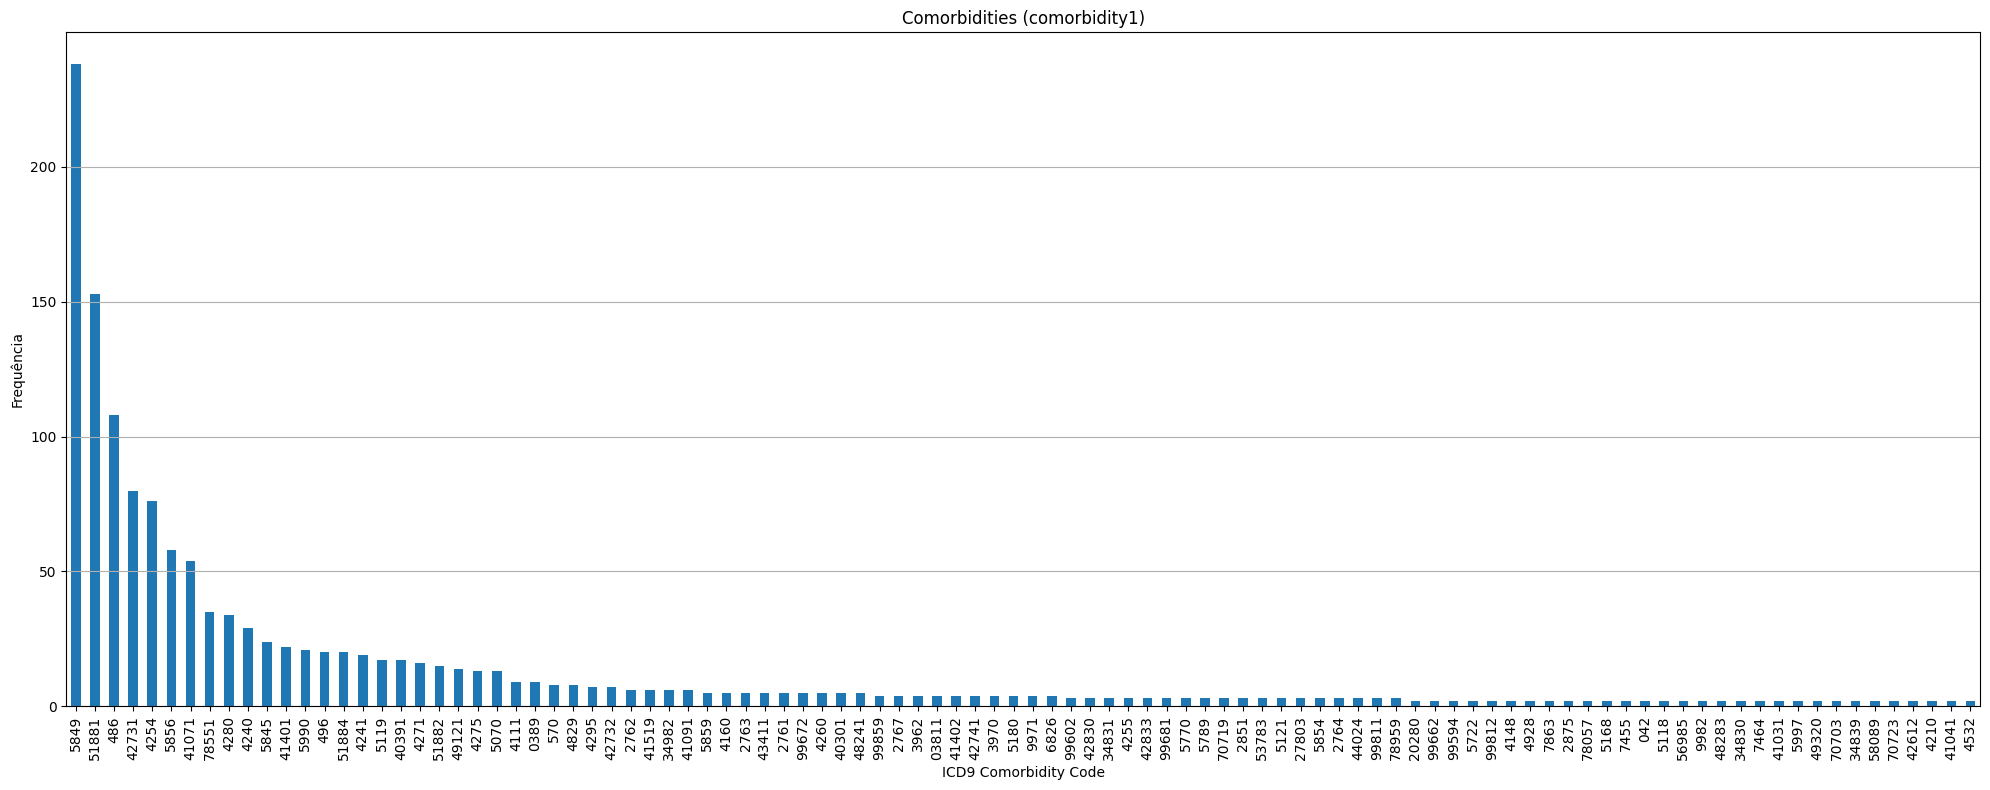

comorbidity1
5849     238
51881    153
486      108
42731     80
4254      76
Name: count, dtype: int64


In [14]:
plt.figure(figsize=(20, 8))
counts_plot = counts1.iloc[:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity1)')
plt.xlabel('ICD9 Comorbidity Code')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print(counts1.iloc[:5])


Percentage of the frequency explained by the top 5 comorbidities2: 26.48 %


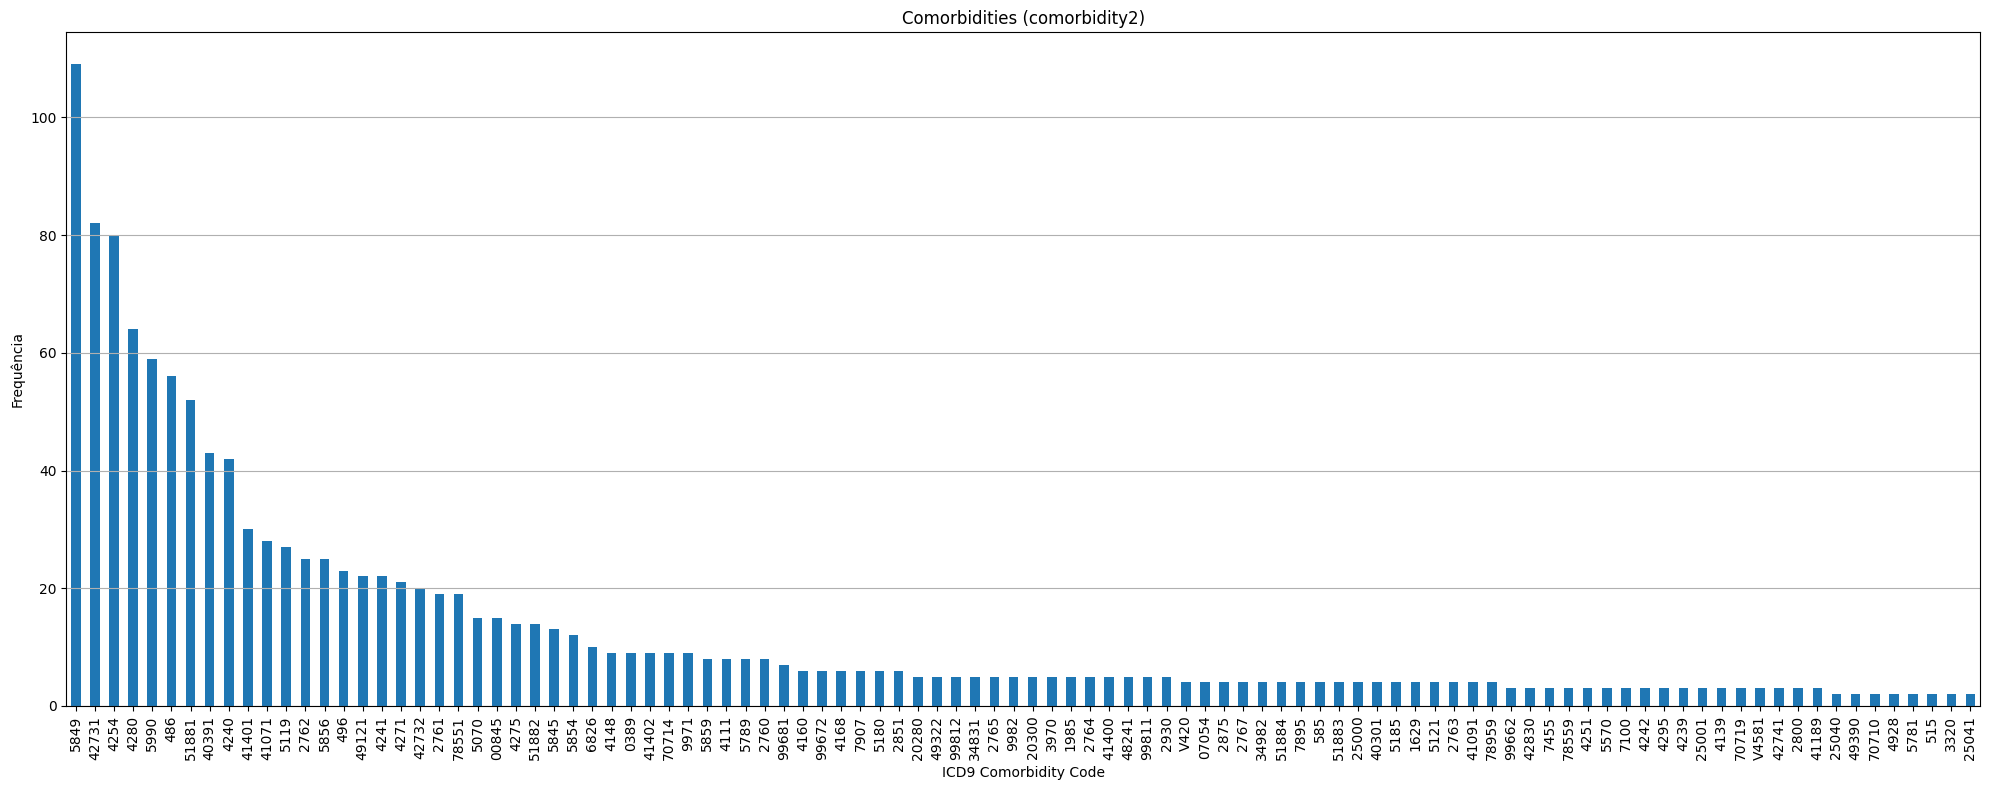

comorbidity2
5849     109
42731     82
4254      80
4280      64
5990      59
Name: count, dtype: int64


In [15]:
counts2_df = diagnoses_disease.groupBy("comorbidity2").count().orderBy(col("count").desc())

counts2 = counts2_df.toPandas().set_index("comorbidity2")["count"]

top5_total = counts2.iloc[:5].sum()
total = counts2.sum()
c2 = top5_total / total

print("Percentage of the frequency explained by the top 5 comorbidities2: {:.2f} %".format(c2 * 100))

plt.figure(figsize=(20, 8))
counts_plot = counts2.iloc[:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity2)')
plt.xlabel('ICD9 Comorbidity Code')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print(counts2.iloc[:5])


## Data preparation

In [16]:
top5 = diagnoses_disease.groupBy("comorbidity1") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(5) \
    .select("comorbidity1") \
    .rdd.flatMap(lambda x: x) \
    .collect()

diagnoses_disease = diagnoses_disease.withColumn(
    "comorbidity1_top5",
    when(col("comorbidity1").isin(top5), col("comorbidity1")).otherwise(lit("Other"))
)

diagnoses_disease_dummy = diagnoses_disease.select("HADM_ID", "comorbidity1_top5") \
    .withColumn("value", lit(1))  # valor binário 1

dummies = diagnoses_disease_dummy.groupBy("HADM_ID") \
    .pivot("comorbidity1_top5") \
    .agg(lit(1))

for c in dummies.columns:
    if c != "HADM_ID":
        dummies = dummies.withColumn(c, coalesce(col(c), lit(0)))

if "Other" in dummies.columns:
    dummies = dummies.drop("Other")

diagnoses_disease = diagnoses_disease.join(dummies, on="HADM_ID", how="left")


In [17]:
top5_c2 = diagnoses_disease.groupBy("comorbidity2") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(5) \
    .select("comorbidity2") \
    .rdd.flatMap(lambda x: x) \
    .collect()

diagnoses_disease = diagnoses_disease.withColumn(
    "comorbidity2_top5",
    when(col("comorbidity2").isin(top5_c2), col("comorbidity2")).otherwise(lit("Other"))
)

diagnoses_disease_dummy = diagnoses_disease.select("HADM_ID", "comorbidity2_top5") \
    .withColumn("value", lit(1))

dummies2 = diagnoses_disease_dummy.groupBy("HADM_ID") \
    .pivot("comorbidity2_top5") \
    .agg(lit(1))

# Substituir nulls por 0
for c in dummies2.columns:
    if c != "HADM_ID":
        dummies2 = dummies2.withColumn(c, coalesce(col(c), lit(0)))

# Remover coluna 'Other' se presente
if "Other" in dummies2.columns:
    dummies2 = dummies2.drop("Other")

diagnoses_disease = diagnoses_disease.join(dummies2, on="HADM_ID", how="left")

for c in dummies2.columns:
    if c != "HADM_ID":
        diagnoses_disease = diagnoses_disease.withColumnRenamed(c, f"comorbidity2_{c}")


In [18]:
print("Number of lines in diagnoses_disease:", diagnoses_disease.count())

Number of lines in diagnoses_disease: 1488


In [19]:
spark.conf.set("spark.sql.session.timeZone", "UTC")

icustays = icustays.withColumn("INTIME", to_timestamp("INTIME"))
chartevents_filtered = chartevents_filtered.withColumn("CHARTTIME", to_timestamp("CHARTTIME"))

merged = chartevents_filtered.join(
    icustays.select("ICUSTAY_ID", "INTIME"),
    on="ICUSTAY_ID",
    how="inner"
)

merged = merged.withColumn(
    "DAYS_FROM_INTIME",
    (col("CHARTTIME").cast("long") - col("INTIME").cast("long")) / 86400.0
)

merged = merged.withColumn(
    "DAYS_FROM_INTIME",
    when(col("DAYS_FROM_INTIME") < 0, lit(0)).otherwise(col("DAYS_FROM_INTIME"))
)

chartevents_first_day = merged.filter(col("DAYS_FROM_INTIME") < 1)

In [20]:
print(chartevents_first_day.count())

1800481


Visualizations

68.9517


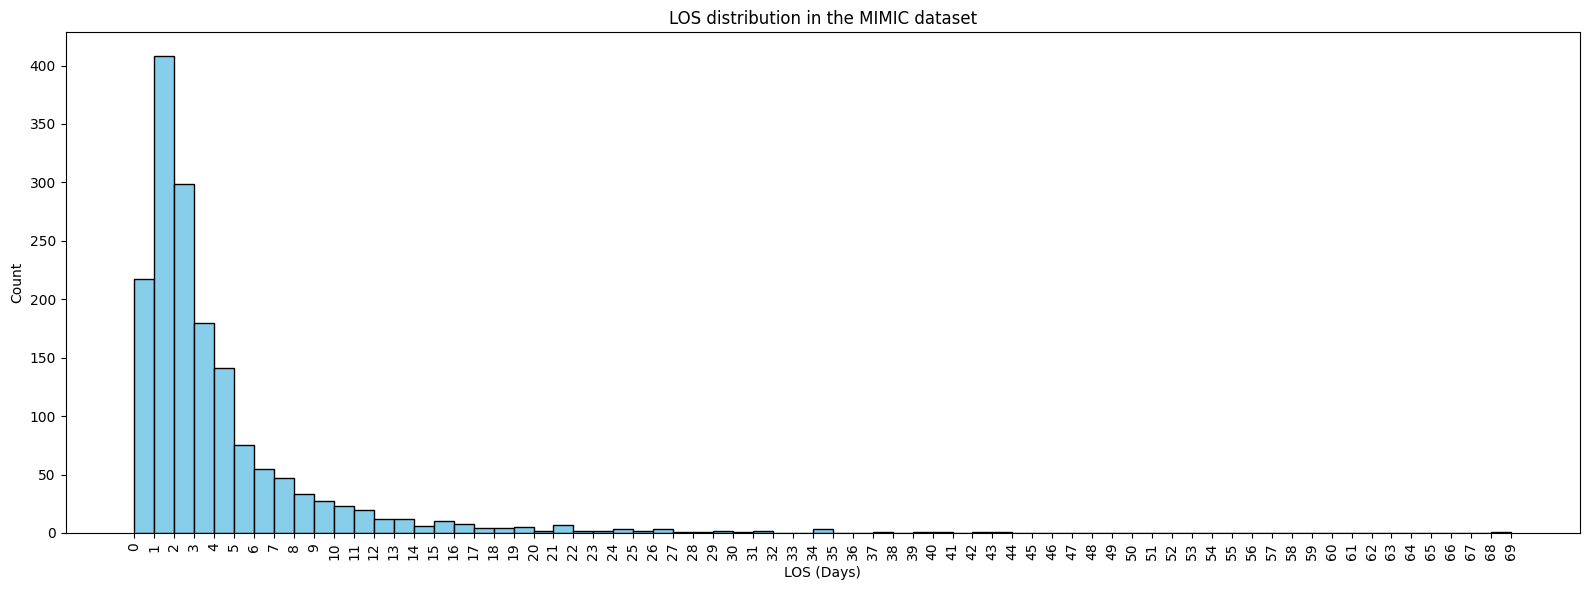

In [21]:
los_values = icustays.select("LOS").dropna().rdd.flatMap(lambda x: x).collect() # rdd: more efficient 

max_los = int(np.ceil(max(los_values)))

print(max(los_values))

plt.figure(figsize=(16, 6))
plt.hist(los_values, bins=np.arange(0, max_los + 1, 1), edgecolor='black', color='skyblue')
plt.title("LOS distribution in the MIMIC dataset")
plt.ylabel("Count")
plt.xlabel("LOS (Days)")
plt.xticks(np.arange(0, max_los + 1, step=1), rotation=90)
plt.tight_layout()
plt.show()

In [22]:
icustays.filter(col("LOS") > 68).select("SUBJECT_ID").show(truncate=False)

+----------+
|SUBJECT_ID|
+----------+
|8868      |
+----------+



-----------------------------

In [23]:
icustays = icustays.filter(col("LOS") < 68)

In [24]:
icustays.filter(col("LOS") > 68).select("SUBJECT_ID").show(truncate=False)

+----------+
|SUBJECT_ID|
+----------+
+----------+



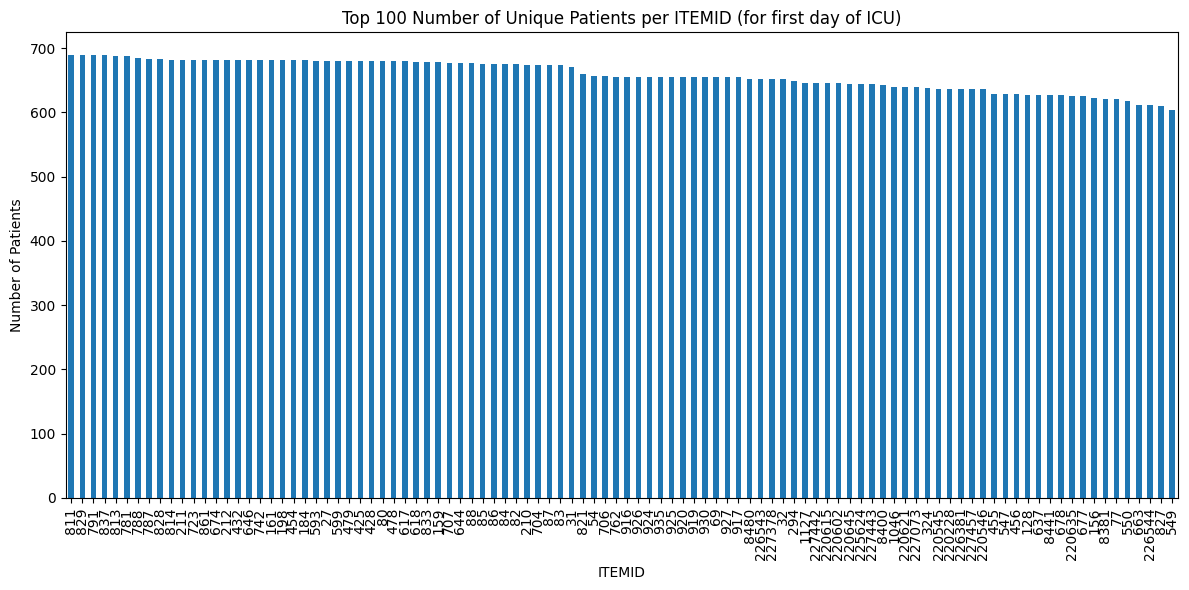

In [25]:
patients_per_item = chartevents_first_day.groupBy("ITEMID") \
    .agg(countDistinct("SUBJECT_ID").alias("num_patients")) \
    .orderBy(col("num_patients").desc()) \
    .limit(100)

patients_per_item_pd = patients_per_item.toPandas()

patients_per_item_pd.set_index("ITEMID").plot(kind='bar', legend=False, figsize=(12,6))
plt.title('Top 100 Number of Unique Patients per ITEMID (for first day of ICU)')
plt.xlabel('ITEMID')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()